/home/juan/.local/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


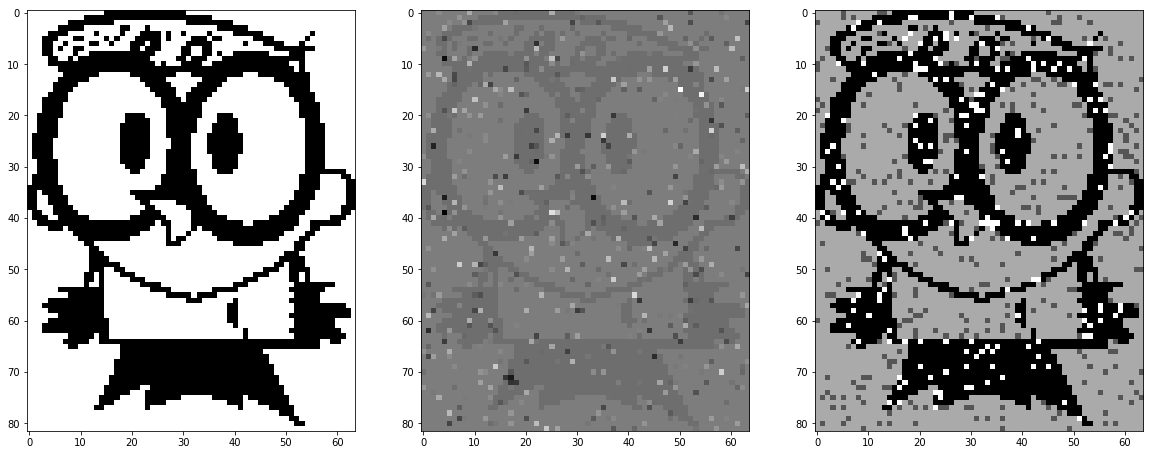

In [248]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
import copy


def add_gaussian_noise(im,prop,varSigma):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im).astype('float')
    im2[index] += e[index]
    return im2

def add_saltnpeppar_noise(im,prop):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]
    return im2

def binaryImage(image):
    cp_image = copy.deepcopy(image)
    for x in range(len(cp_image)):
        for y in range(len(cp_image[0])):
            cp_image[x][y] = round(cp_image[x][y])
            if cp_image[x][y] < 0.5:
                cp_image[x][y] = -1
    return cp_image
# proportion of pixels to alter

prop = 0.1
varSigma = 5
im = misc.imread('images/dexter.jpg')
im = im/255
im = binaryImage(im)
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
ax = fig.add_subplot(131)
ax.imshow(im,cmap='gray')
im2 = add_gaussian_noise(im,prop,varSigma)
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')
im3 = add_saltnpeppar_noise(im,prop)
ax3 = fig.add_subplot(133)
ax3.imshow(im3,cmap='gray')


In [152]:
def neighbours(i,j,M,N,size=8):
    if size==4:
        if (i==0 and j==0):
            n=[(0,1), (1,0)]
        elif i==0 and j==N-1:
            n=[(0,N-2), (1,N-1)]
        elif i==M-1 and j==0:
            n=[(M-1,1), (M-2,0)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2), (M-2,N-1)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        else:
            n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        return n
    if size==8:
        if (i==0 and j==0):
            n=[(0,1), (1,0), (1, 1)]
        elif i==0 and j==N-1:
            n=[(0,N-2), (1, N-2), (1,N-1)]
        elif i==M-1 and j==0:
            n=[(M-1,1), (M-2,0), (M-2, 1)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2), (M-2,N-1),  (M-2, N-2)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j), (1,j-1), (1,j+1)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j), (M-2,j-1), (M-2,j+1)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1), (i-1,1), (i+1,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2), (i-1,N-2), (i+1,N-2)]
        else:
             n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1), (i-1, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)]
        return n

In [154]:
def calculateEnergy(latent, noisy, i, j, beta, eta):
    n = neighbours(i, j, latent.shape[0], latent.shape[1])
    energy = eta*(latent[i][j]*noisy[i][j])
    for m in n:
        x, y = m
        energy += (beta * latent[x][y] * latent[i][j])
    return energy

def convertLatent(latent):
    for i in range(latent.shape[0]):
        for j in range(latent.shape[1]):
            if latent[i][j] == 0:
                latent[i][j] = -1
    return latent
    
def ICM(image, beta, eta, runs):
    latentImage = np.random.randint(2, size=(image.shape))

#    latentImage = convertLatent(latentImage)
    for n in range(runs):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                bros = neighbours(i, j, latentImage.shape[0], latentImage.shape[1])
                latentImage[i][j] = 1
                posEnergy = calculateEnergy(latentImage, image, i,j, beta, eta)
                for m in bros:
                    x, y = m
                    posEnergy += calculateEnergy(latentImage, image, x, y, beta, eta)
                latentImage[i][j] = -1
                negEnergy = calculateEnergy(latentImage, image, i,j, beta, eta)
                for m in bros:
                    x, y = m
                    negEnergy += calculateEnergy(latentImage, image, x, y, beta, eta)
                if posEnergy > negEnergy:
                    latentImage[i][j] = 1
                else:
                    latentImage[i][j] = -1
    return latentImage

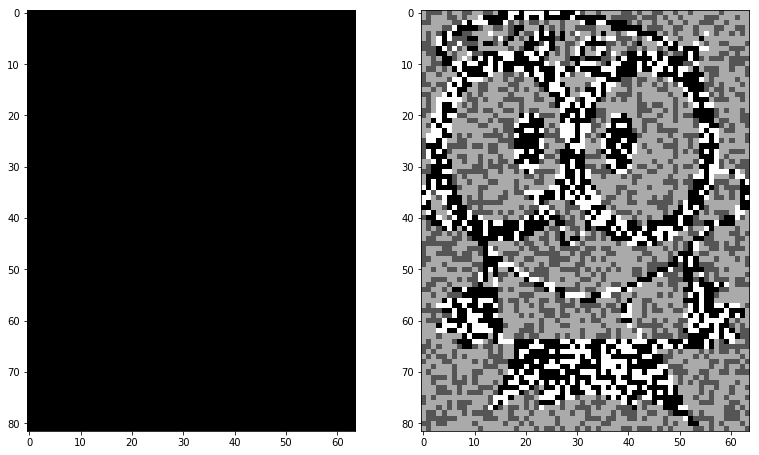

In [245]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
ax = fig.add_subplot(131)
ax.imshow(ICM(im3, 0.5, 0.4, 5),cmap='gray')
ax2 = fig.add_subplot(132)
ax2.imshow(im3,cmap='gray')

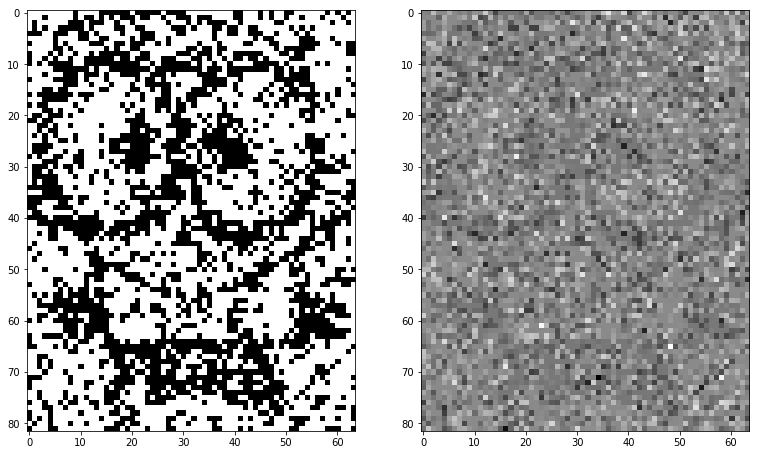

In [195]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
ax = fig.add_subplot(131)
ax.imshow(ICM(im2, 0.1, 1, 10),cmap='gray')
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')

In [6]:
def likelihood(latent, noisy, x, y, eta):
    bros = neighbours(x, y, latent.shape[0], latent.shape[1])
    likelihood = eta*latent[x][y]*noisy[x][y]
#     for m in bros:
#         i, j = m
#         likelihood = likelihood * np.exp(eta*latent[i][j]*noisy[i][j])
    return likelihood

def prior(latent, x, y, beta):
    prior = 0
    first = neighbours(x, y, latent.shape[0], latent.shape[1])
    for i, j in first:
#         second = neighbours(i, j, latent.shape[0], latent.shape[1])
        prior += beta*latent[x][y]*latent[i][j]
#         for m, n in second:
#             prior += beta*latent[m][n]*latent[i][j]
    return prior

def energy(l, p):
    return np.exp(l + p)
    
        

In [7]:
originalImage = convertLatent(im)
def totalBlack(image):
    black = 0
    for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                if image[i][j] == -1:
                    black += 1
    return black
def pixelPercentage(latent, real):    
    counter = 0
    totalPix = totalBlack(real)
    for i in range(latent.shape[0]):
        for j in range(latent.shape[1]):
            if latent[i][j] == -1 and real[i][j] == -1:
                counter += 1
    return counter/totalPix
    

In [8]:
import math
def gibbsy(image, beta, eta,runs):
    latentImage = copy.deepcopy(image)
    for n in range(runs):
        print("PIXEL SIMILARITY: " + str(pixelPercentage(latentImage, originalImage)))
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                latentImage[i][j] = 1
                posEnergy = math.exp(calculateEnergy(latentImage, image, i, j, beta, eta))
                latentImage[i][j] = -1
                negEnergy = math.exp(calculateEnergy(latentImage, image, i, j, beta, eta))
                post = posEnergy/(posEnergy + negEnergy)
                r = np.random.uniform(0,1)
                if post >= r:
                    latentImage[i][j] = 1
                else:
                    latentImage[i][j] = -1
    return latentImage
                

                

PIXEL SIMILARITY: 0.7913553895410885
PIXEL SIMILARITY: 0.9343649946638207
PIXEL SIMILARITY: 0.927427961579509
PIXEL SIMILARITY: 0.9332977588046958
PIXEL SIMILARITY: 0.9338313767342583
PIXEL SIMILARITY: 0.9375667022411953
PIXEL SIMILARITY: 0.9364994663820705
PIXEL SIMILARITY: 0.9290288153681964
PIXEL SIMILARITY: 0.9311632870864461
PIXEL SIMILARITY: 0.927427961579509


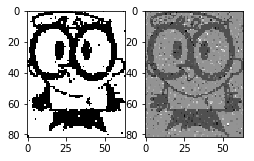

In [141]:
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(gibbsy(im2, 0.5, 1, 10),cmap='gray')
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')

PIXEL SIMILARITY: 0.8052294557097118
PIXEL SIMILARITY: 0.8009605122732124
PIXEL SIMILARITY: 0.804162219850587
PIXEL SIMILARITY: 0.8030949839914621
PIXEL SIMILARITY: 0.804162219850587
PIXEL SIMILARITY: 0.8036286019210246
PIXEL SIMILARITY: 0.8020277481323372
PIXEL SIMILARITY: 0.8036286019210246
PIXEL SIMILARITY: 0.8030949839914621
PIXEL SIMILARITY: 0.804162219850587


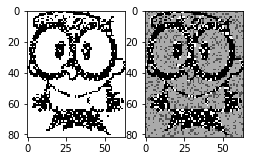

In [142]:
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(gibbsy(im3, 0.7, 4, 10),cmap='gray')
ax2 = fig.add_subplot(132)
ax2.imshow(im3,cmap='gray')

In [265]:
def gibbs(image, beta, eta, runs):
    latentImage = copy.copy(image) 
    #np.random.randint(2, size=(image.shape))
    iternNumber = 0
    for n in range(runs):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                bros = neighbours(i, j, latentImage.shape[0], latentImage.shape[1])
                latentImage[i][j] = 1
                posEnergy = calculateEnergy(latentImage, image, i,j, beta, eta)
                for m in bros:
                    x, y = m
                    posEnergy += calculateEnergy(latentImage, image, x, y, beta, eta)
                posEnergy = np.exp(posEnergy)
                
                latentImage[i][j] = -1
                negEnergy = calculateEnergy(latentImage, image, i,j, beta, eta)
                for m in bros:
                    x, y = m
                    negEnergy += calculateEnergy(latentImage, image, x, y, beta, eta)
                negEnergy = np.exp(negEnergy)
                joint = posEnergy/(posEnergy+negEnergy)
                negJoint = negEnergy/(posEnergy+negEnergy)
                r = np.random.uniform(0,1)
                if joint >= r:
                    latentImage[i][j] = 1
                else:
                    latentImage[i][j] = -1
                iternNumber += 1
    print("PIXEL SIMILARITY: " + str(pixelPercentage(latentImage, originalImage)))
    print(iternNumber)
    return latentImage

PIXEL SIMILARITY: 0.7449306296691569
52480


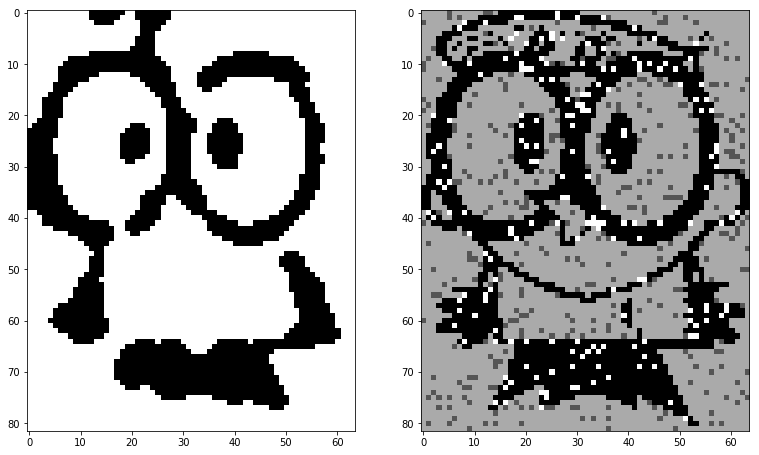

In [270]:
fig = plt.figure()
ax = fig.add_subplot(131)
fig.set_figheight(20)
fig.set_figwidth(20)
ax.imshow(gibbs(im3, 1, 2, 10),cmap='gray')
ax2 = fig.add_subplot(132)
ax2.imshow(im3,cmap='gray')

PIXEL SIMILARITY: 0.7113127001067235
26240


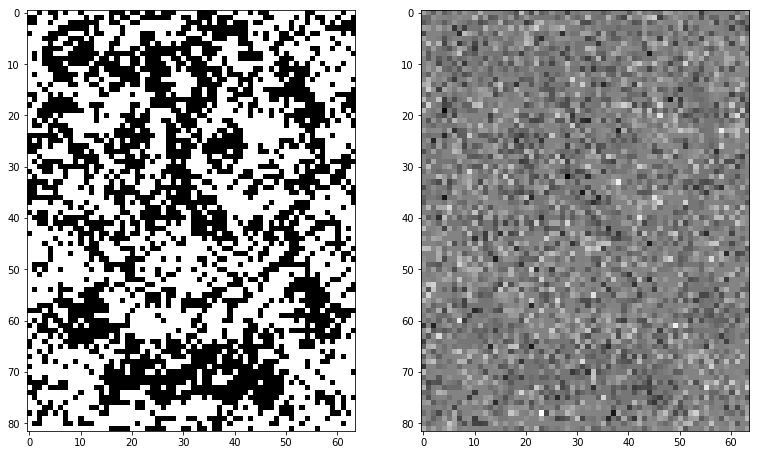

In [233]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
ax = fig.add_subplot(131)
ax.imshow(gibbs(im2, 0.1, 1, 5),cmap='gray')
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')

In [14]:
# np.random.seed(42)

In [15]:

def randomGibbs(image, beta, eta, runs):
    latentImage = np.random.randint(2, size=(image.shape))
    for i in range(runs):
        i = np.random.randint(0, image.shape[0])
        j = np.random.randint(0, image.shape[1])
        bros = neighbours(i, j, latentImage.shape[0], latentImage.shape[1])
        latentImage[i][j] = 1
        posEnergy = calculateEnergy(latentImage, image, i,j, beta, eta)
        for m in bros:
            x, y = m
            posEnergy += calculateEnergy(latentImage, image, x, y, beta, eta)
        posEnergy = np.exp(posEnergy)

        latentImage[i][j] = -1
        negEnergy = calculateEnergy(latentImage, image, i,j, beta, eta)
        for m in bros:
            x, y = m
            negEnergy += calculateEnergy(latentImage, image, x, y, beta, eta)
        negEnergy = np.exp(negEnergy)
        joint = posEnergy/(posEnergy+negEnergy)
        negJoint = negEnergy/(posEnergy+negEnergy)
        r = np.random.uniform(0,1)
        if joint >= r:
            latentImage[i][j] = 1
        else:
            latentImage[i][j] = -1
    print("PIXEL SIMILARITY: " + str(pixelPercentage(latentImage, originalImage)))
    return latentImage
    

PIXEL SIMILARITY: 0.5933831376734259


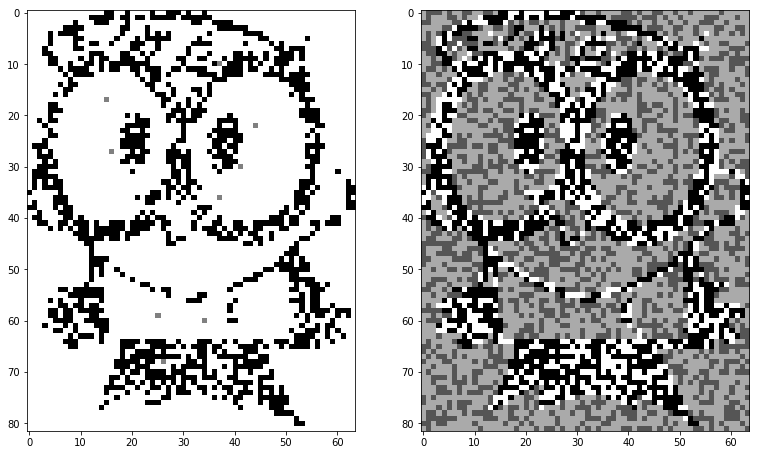

In [239]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
ax = fig.add_subplot(131)
ax.imshow(randomGibbs(im3, 0.6, 25, 30000),cmap='gray')
ax2 = fig.add_subplot(132)
ax2.imshow(im3,cmap='gray')